# Agenda
- CV
- Gradient Descent
- Logistic Regression

In [3]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    # NEW
    "torch",
    "mlbench"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

Loading required package: torch

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'torch'"
Loading required package: mlbench

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'mlbench'"


ISLR2   dplyr   tidyr   readr   purrr  glmnet   caret    repr   torch mlbench 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE   FALSE   FALSE

## Cross validation

In [14]:
df <- Boston %>% drop_na()
head(df)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7


Split the data into training and testing sets

In [11]:
# randomly sample half of the data
fold <- sample(1:nrow(df), nrow(df)/2)

[1] 253

In [12]:
train <- df %>% slice(-fold)
test <- df %>% slice(fold)

In [13]:
nrow(train) + nrow(test)

[1] 506

In [16]:
mod1 <- lm(medv ~ ., data = train)
summary(mod1)


Call:
lm(formula = medv ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4469 -2.8633 -0.3378  1.4369 24.2307 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  49.734622   7.726407   6.437 6.57e-10 ***
crim         -0.144390   0.051901  -2.782 0.005832 ** 
zn            0.060788   0.019950   3.047 0.002570 ** 
indus        -0.057421   0.092692  -0.619 0.536185    
chas          4.089622   1.264033   3.235 0.001386 ** 
nox         -16.828232   5.667477  -2.969 0.003288 ** 
rm            2.419061   0.661545   3.657 0.000314 ***
age           0.005604   0.019131   0.293 0.769847    
dis          -1.707481   0.316796  -5.390 1.68e-07 ***
rad           0.322732   0.097790   3.300 0.001113 ** 
tax          -0.010705   0.005411  -1.979 0.049011 *  
ptratio      -0.942242   0.198621  -4.744 3.60e-06 ***
lstat        -0.646179   0.076710  -8.424 3.37e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual 

In [19]:
y_test <- predict(mod1, newdata = test)
length(y_test)

[1] 253

In [21]:
mspe <- mean((test$medv - y_test)^2)

## k-Fold Cross Validation

In [32]:
k <- 5
# randomly assign group to each row
folds <- sample(1:k, nrow(df), replace = T)

df_folds <- list()

for (i in 1:k){
    df_folds[[i]] <- list()
    df_folds[[i]]$train <- df[which(folds != i), ]
    df_folds[[i]]$test <- df[which(folds == i), ]
}

In [34]:

kfold_mspe <- c()
for ( i in 1:k){
    model <- lm(medv ~ ., df_folds[[i]]$train)
    yhat <- predict(model, newdata = df_folds[[i]]$test)
    kfold_mspe[i] <- mean((yhat - df_folds[[i]]$test$medv)^2)
}
kfold_mspe
mean(kfold_mspe)


[1] 35.42501 29.06530 17.71910 32.00952 16.54434

[1] 26.15266

In [36]:
make_fold <- function(df, k){
    fold <- sample(1:k, nrow(df), replace=T)
    df_folds <- list()

    for (i in 1:k){
        df_folds[[i]] <- list()
        df_folds[[i]]$train <- df[which(folds != i), ]
        df_folds[[i]]$test <- df[which(folds == i), ]
    }
    return(df_folds)
}

cv_mspe <- function(formula, df_folds){
    kfold_mspe <- c()
    for ( i in 1:k){
        model <- lm(formula, df_folds[[i]]$train)
        yhat <- predict(model, newdata = df_folds[[i]]$test)
        kfold_mspe[i] <- mean((yhat - df_folds[[i]]$test$medv)^2)
    }
    return(mean(kfold_mspe))
}

In [39]:
cv_mspe(medv~1, df_folds)
cv_mspe(medv~., df_folds)

[1] 85.00916

[1] 26.15266

## Wrapped in a function

### Using the`caret` package

Define the training control for cross validation

In [41]:
ctrl <- trainControl(method = "cv", number=5)

In [45]:
model <- train(medv ~ ., data = df, method = "lm", trControl = ctrl)
predict(model, df)

1          2          3          4          5          6          7 
30.0337381 25.0568337 30.6081860 28.6771795 27.9287910 25.3931686 22.8049615 
         8          9         10         11         12         13         14 
19.1989850 11.0789798 18.7196691 18.6243863 21.3924635 20.6074548 19.5425861 
        15         16         17         18         19         20         21 
19.4233883 19.2985478 20.5613455 16.8774753 17.0918004 18.4376069 12.5239462 
        22         23         24         25         26         27         28 
17.6346928 15.5984260 13.6377991 15.5739012 14.1458082 15.5651598 15.3585853 
        29         30         31         32         33         34         35 
19.5109376 20.8864623 11.5264829 18.1976370  9.8599843 14.4939560 14.8321298 
        36         37         38         39         40         41         42 
23.8345596 22.4881910 23.0793851 22.8302054 31.4305510 34.2692210 27.9984533 
        43         44         45         46         47         48         49 
25.2761181 24.5274389 22.9686359 22.0853221 20.2869496 17.9181010  8.7432472 
        50         51         52         53         54         55         56 
17.1102100 21.1539397 23.9970620 27.5840259 23.9700939 15.2685035 31.0754735 
        57         58         59         60         61         62         63 
24.9129546 33.1530689 21.7362506 21.0232571 17.7990395 18.6120928 23.9689256 
        64         65         66         67         68         69         70 
22.3430303 23.3502180 30.3789932 25.5112704 21.0913879 17.3440859 20.7694558 
        71         72         73         74         75         76         77 
25.2004117 21.8187279 24.5790993 24.1041109 25.3393654 23.9590876 23.0380361 
        78         79         80         81         82         83         84 
23.3090221 21.1582698 22.3346551 28.3995872 27.0719251 26.0513565 25.1739017 
        85         86         87         88         89         90         91 
24.7503577 27.8755201 22.1080950 25.9887587 30.7572678 30.8376480 27.1910970 
        92         93         94         95         96         97         98 
27.5133057 28.8860687 29.0299080 26.9999881 29.0593763 24.8238118 35.7544886 
        99        100        101        102        103        104        105 
35.0604597 32.2303346 24.4986679 25.5186301 22.7570127 20.2347664 21.4132145 
       106        107        108        109        110        111        112 
18.4651746 17.0241789 20.7241671 22.5786800 19.6667909 20.4891912 26.3078249 
       113        114        115        116        117        118        119 
20.5555270 20.4314828 25.0933076 20.6724686 23.1833002 23.5851282 20.6118606 
       120        121        122        123        124        125        126 
20.6174283 21.7702856 22.4572393 20.4734624 16.1805268 20.4966614 22.4018684 
       127        128        129        130        131        132        133 
14.5156172 14.9326860 18.5920004 13.7271712 19.7733174 19.1429295 19.9303324 
       134        135        136        137        138        139        140 
15.5701020 14.1907977 16.8992372 15.7206609 19.0574377 13.4403004 16.0575541 
       141        142        143        144        145        146        147 
13.0951173  3.3296712 13.8845926 11.2744786  7.8735925 13.1320375 17.3325525 
       148        149        150        151        152        153        154 
 7.6962799  9.2104776 14.4672043 20.4469068 18.3415940 20.3617725 17.9399787 
       155        156        157        158        159        160        161 
22.5783357 22.4176200 15.9270593 33.3559304 29.3058463 25.3876828 33.2527441 
       162        163        164        165        166        167        168 
36.7395662 40.4973683 41.6624964 24.5246023 26.5665606 37.1029733 24.3350841 
       169        170        171        172        173        174        175 
27.0122213 26.9308012 23.1912155 24.4652428 22.9417242 29.0631106 26.5567233 
       176        177        178        179        180        181        182 
30.6810561 25.5387181 29.177020

### `caret` for LASSO

#### Bias-variance tradeoff

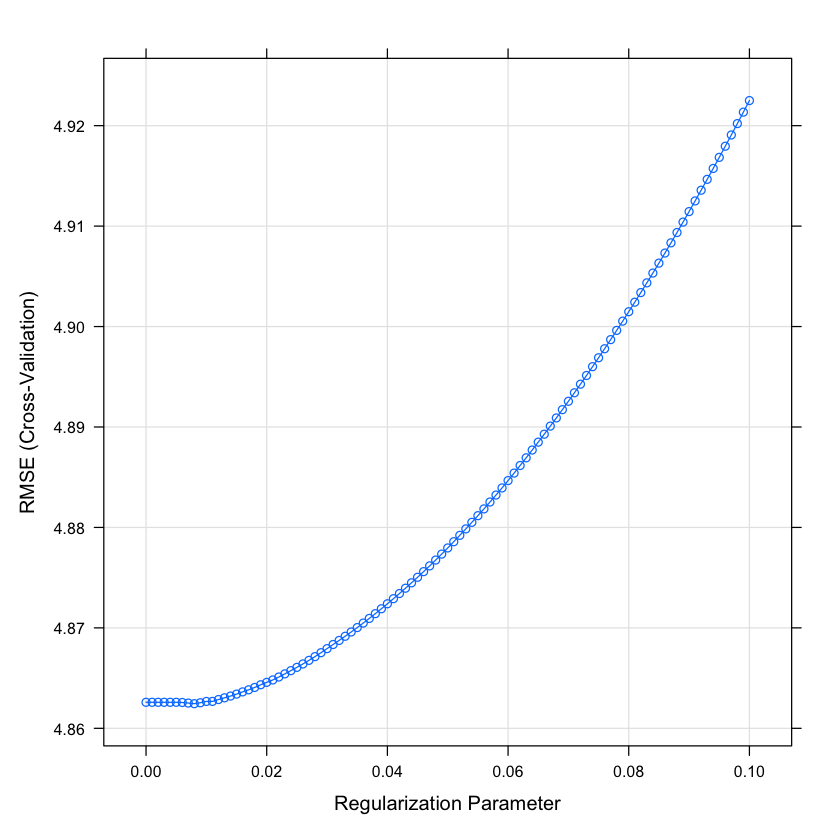

In [49]:
ctrl <- trainControl(method="cv", number = 5)
grid <- expand.grid(alpha = 1, lambda = seq(0, 0.1, by=0.001))
lasso_fit <- train(medv ~. , data=df, method = "glmnet", trControl = ctrl, tuneGrid = grid, standardize= TRUE, family="gaussian")
plot(lasso_fit)